In [ ]:
#GPU

In [1]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else ("CPU")

device

device(type='cuda')

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Load the dataset
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'label'
]

data = pd.read_csv('Downloads/KDD Cup/kddcup.data_10_percent.gz', header=None, names=column_names)

In [4]:
# Data Preprocessing
le = LabelEncoder()
data['protocol_type'] = le.fit_transform(data['protocol_type'])
data['service'] = le.fit_transform(data['service'])
data['flag'] = le.fit_transform(data['flag'])
data['label'] = le.fit_transform(data['label'])

X = data.drop('label', axis=1).values
y = data['label'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = X.reshape(X.shape[0], 1, X.shape[1])  # Reshape for CNN

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [5]:
# Define the CNN Model
class IntrusionDetectionCNN(nn.Module):
    def __init__(self):
        super(IntrusionDetectionCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(448, 64)  # Adjust according to input size after conv layers
        self.fc2 = nn.Linear(64, 23)  # Assuming 23 classes for KDD

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Adjust according to your architecture
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
model = IntrusionDetectionCNN()

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

IntrusionDetectionCNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=448, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=23, bias=True)
)

In [6]:
# DataLoader
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
test_dataset = TensorDataset(X_test.to(device), y_test.to(device))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
import torch.nn.functional as F 
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate the Model
model.eval()
correct = 0
total = 0

Epoch [1/10], Loss: 0.0003
Epoch [2/10], Loss: 0.0002
Epoch [3/10], Loss: 0.0001
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0279
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000


In [9]:
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.89%


In [10]:
# Predictions
with torch.no_grad():
    predictions = model(X_test.to(device))
    predicted_classes = torch.argmax(predictions, dim=1)

# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test.numpy(), predicted_classes.cpu().numpy()))

[[  434     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0]
 [    0     5     0     0     0     0     0     0     0     0     0     3
      0     0     0     0     0     0     1     0]
 [    0     0     0     0     0     0     0     0     1     0     0     0
      0     0     0     0     0     0     0     0]
 [    0     0     0     7     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     1     0     0     0     0     0     0     1
      0     0     0     0     0     0     1     0]
 [    0     0     0     0     0   259     0     0     0     0     1     5
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     1     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     2     0     0     0
      0     0     0     0     0     0     0     0]


In [11]:
print(classification_report(y_test.numpy(), predicted_classes.cpu().numpy()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       435
           1       0.83      0.56      0.67         9
           2       0.00      0.00      0.00         1
           3       1.00      0.88      0.93         8
           4       1.00      0.33      0.50         3
           5       0.98      0.98      0.98       265
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         2
           8       0.14      1.00      0.25         1
           9       1.00      1.00      1.00     21294
          10       0.98      0.93      0.95        45
          11       1.00      1.00      1.00     19353
          12       0.00      0.00      0.00         1
          14       0.97      0.97      0.97        38
          15       0.99      1.00      0.99       236
          17       1.00      0.96      0.98       304
          18       1.00      1.00      1.00     56402
          20       1.00    

C:\Users\chirr\anaconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chirr\anaconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\chirr\anaconda3\envs\deep\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

C:\Users\chirr\anaconda3\envs\deep\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\chirr\anaconda3\envs\deep\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\chirr\anaconda3\envs\deep\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


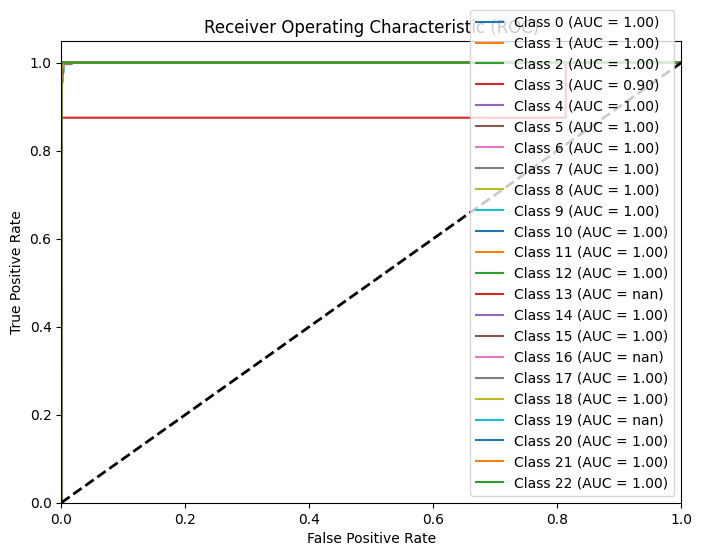

In [15]:
# Assuming you already have `all_labels` and `all_probs` from the previous step

# 1. Plotting the ROC Curve and AUC
num_classes = 23
def plot_roc_curve(y_true, y_probs, num_classes):
    plt.figure(figsize=(8, 6))
    
    # For multi-class classification
    if num_classes > 2:
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    else:
        fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])  # Positive class probabilities
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Call the function to plot the ROC curve
plot_roc_curve(all_labels, all_probs, num_classes)

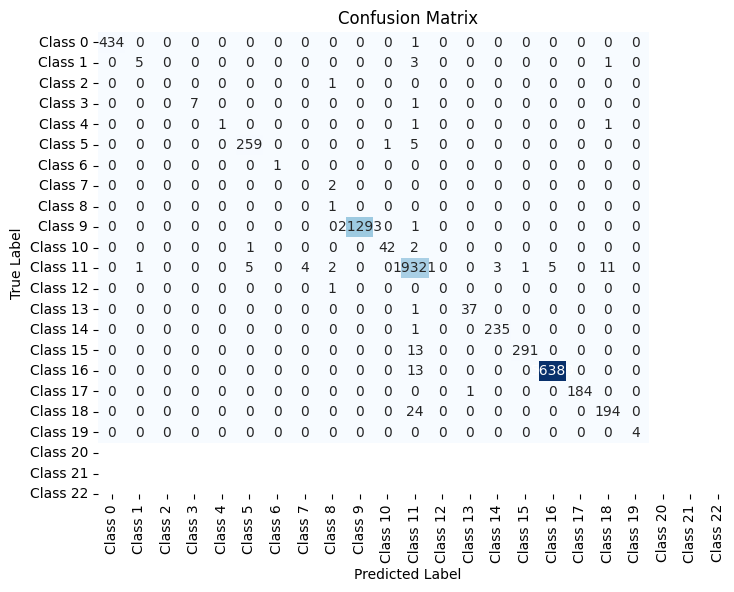

In [16]:
# 2. Plotting the Confusion Matrix
num_classes = 23
def plot_confusion_matrix(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=[f'Class {i}' for i in range(num_classes)],
                yticklabels=[f'Class {i}' for i in range(num_classes)])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example: Getting predicted classes
y_pred = np.argmax(all_probs, axis=1)  # For multi-class, use argmax
# For binary, y_pred = (all_probs[:, 1] > 0.5).astype(int)

# Call the function to plot the Confusion Matrix
plot_confusion_matrix(all_labels, y_pred, num_classes)
